In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [151]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'season', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [152]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [153]:
team_1 = 'Kings XI Punjab'
team_2 = 'Rajasthan Royals'

In [154]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

# Winning Probability of Teams

Text(0.5, 1.0, 'RR Total Runs Score Stats Per Count')

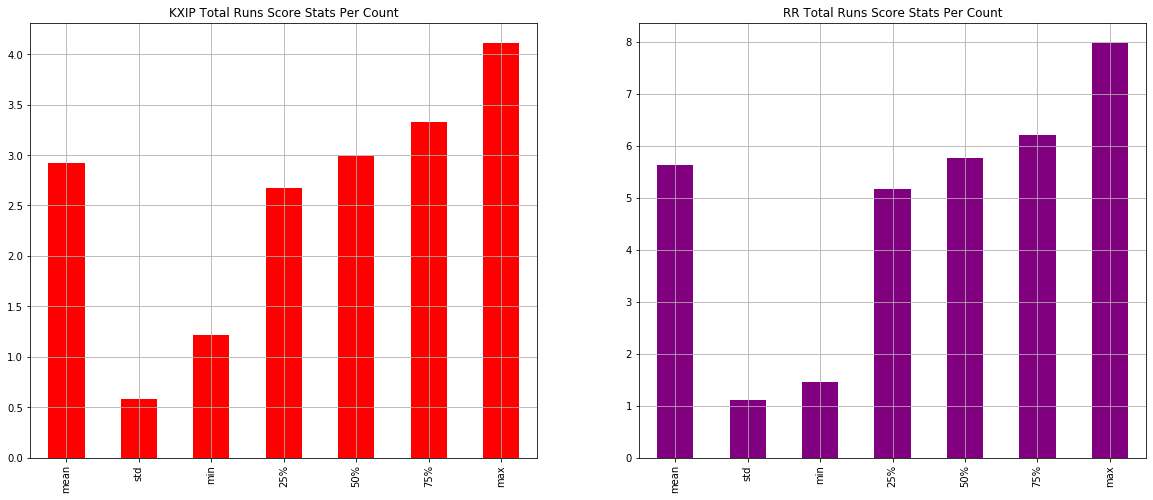

In [155]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
kxip_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
rr_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(kxip_runs.describe()[1:]/kxip_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='r')
(rr_runs.describe()[1:]/rr_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='purple')
ax[0].set_title("KXIP Total Runs Score Stats Per Count")
ax[1].set_title("RR Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

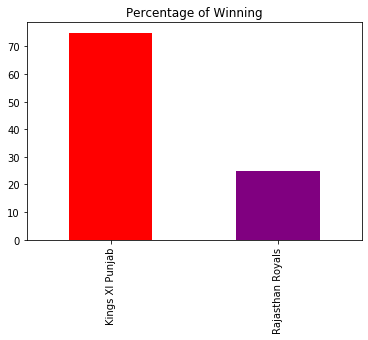

In [156]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['r', 'purple'])
plt.title('Percentage of Winning')

# Highest boundary score to total runs

In [157]:
rr_team = ['BA Stokes', 'RV Uthappa', 'SV Samson', 'SPD Smith', 'JC Buttler', 'R Tewatia', 'J Archer', 'AS Rajpoot', 'S Gopal']
kxip_team = ['KL Rahul', 'Mandeep Singh', 'CH Gayle', 'N Pooran', 'GJ Maxwell', 'CJ Jordan', 'M Ashwin', 'Mohammed Shami']

In [158]:
def boundary_ratio(batsman):
    batsman_ratio = list()
    for man in batsman:
        for match_id in delivery[(delivery['batsman']==man)]['match_id'].unique():
            ratio = 0
            match = delivery[(delivery['match_id']==match_id) & (delivery['batsman']==man)]
            b_runs = sum(match[(match['batsman_runs'].isin([4, 6]))]['batsman_runs'])
            t_runs = sum(match['batsman_runs'])
            if t_runs > 0 and len(match['batsman_runs']) >= 10:
                ratio = b_runs / t_runs
            batsman_ratio.append([man, ratio])

    return batsman_ratio

In [159]:
players = rr_team+kxip_team

Text(0.5, 1.0, 'Boundaries Runs to Total Runs Per Match Mean Ratio of Batsmen')

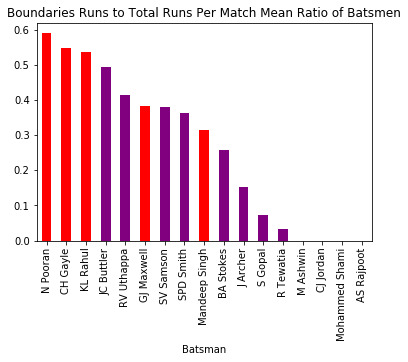

In [176]:
ratio_df = pd.DataFrame(data=boundary_ratio(players), columns=['Batsman', 'Ratio'])
color_ratio = ratio_df.groupby('Batsman').mean().sort_values(by='Ratio',ascending=False).reset_index()['Batsman'].apply(lambda x: 'purple' if x in rr_team else 'red')
ratio_df.groupby('Batsman').mean()['Ratio'].sort_values(ascending=False).plot(kind='bar', color=color_ratio)
plt.title('Boundaries Runs to Total Runs Per Match Mean Ratio of Batsmen')

# OPP  

In [161]:
def batsman_opp(batsman):
    batsman_performance = list()
    for man in batsman:
        for match_id in delivery[(delivery['batsman']==man)]['match_id'].unique():
            opp = 0  
            match = delivery[(delivery['match_id']==match_id) & (delivery['batsman']==man)]
            b_runs = sum(match[(match['batsman_runs'].isin([4, 6]))]['batsman_runs'])
            t_runs = sum(match['batsman_runs'])
            s_runs = sum(match[(match['batsman_runs'].isin([1, 2, 3]))]['batsman_runs'])
            balls = len(match['batsman_runs'])
            if balls>0:
                opp = ((t_runs/balls) + b_runs - s_runs)/balls   
            batsman_performance.append([man, opp])
            
    return batsman_performance

In [162]:
def bowler_opp(bowlers):
    bowler_performance = list()
    for bowler in bowlers:
        for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
            opp=0
            match = delivery[(delivery['match_id']==match_id) & (delivery['bowler']==bowler)]
            b_runs = sum(match[(match['batsman_runs'].isin([4, 6]))]['batsman_runs'])
            t_boundaries = len(match[(match['batsman_runs'].isin([4, 6]))]['batsman_runs'])
            balls = len(match)
            if (balls>0) & (t_boundaries>0):
                opp = (b_runs/t_boundaries)/balls  
                
            bowler_performance.append([bowler, opp])
    return bowler_performance

In [163]:
def normalize(values):
    max_value = max(values)
    min_value = min(values)
    new = list()
    for v in values:
        new_v = (v - min_value)/(max_value-min_value)
        new.append(new_v)
    return new
    

Text(0.5, 1.0, "Batsman's OPP")

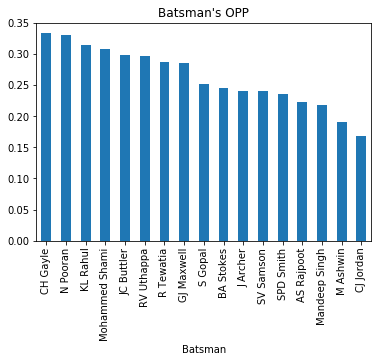

In [164]:
batsman_opp_df = pd.DataFrame(data= batsman_opp(players), columns=['Batsman', 'OPP'])
batsman_opp_df['OPP'] = normalize(batsman_opp_df['OPP'])
batsman_opp_df.groupby('Batsman').mean()['OPP'].sort_values(ascending=False).plot(kind='bar')
plt.title("Batsman's OPP")

Text(0.5, 1.0, "Bowler's OPP")

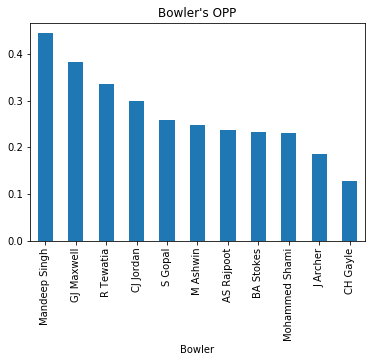

In [165]:
bowlers_opp_df = pd.DataFrame(data=bowler_opp(players), columns=['Bowler', 'OPP'])
bowlers_opp_df['OPP'] = normalize(bowlers_opp_df['OPP'])
bowlers_opp_df.groupby('Bowler').mean()['OPP'].sort_values(ascending=False).plot(kind='bar')
plt.title("Bowler's OPP")

In [166]:
bowl_opp = bowlers_opp_df.groupby('Bowler').mean()
bat_opp = batsman_opp_df.groupby('Batsman').mean()

In [167]:
team_opp = pd.merge(bat_opp, bowl_opp, how='outer', suffixes=('_batsman', '_bowler'), left_index=True, right_index=True).fillna(0)
team_opp['Total OPP'] = team_opp['OPP_batsman'] + team_opp['OPP_bowler']
team_opp.sort_values(by='Total OPP', ascending=False).head()

,OPP_batsman,OPP_bowler,Total OPP
GJ Maxwell,0.285587,0.383629,0.669216
Mandeep Singh,0.218593,0.444444,0.663037
R Tewatia,0.287930,0.336347,0.624277
Mohammed Shami,0.308776,0.230262,0.539038
S Gopal,0.251483,0.259540,0.511023


Text(0.5, 1.0, 'Total OPP of players playing today')

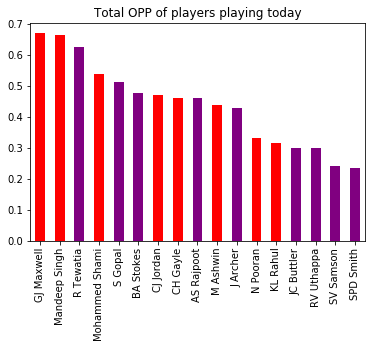

In [168]:
colours = team_opp['Total OPP'].sort_values(ascending=False).reset_index()['index'].apply(lambda x: 'purple' if x in rr_team else 'red')
team_opp['Total OPP'].sort_values(ascending=False).plot(kind='bar', color=colours)
plt.title("Total OPP of players playing today")

# Dot Balls in entire match

count    56.000000
mean     39.089286
std       8.515818
min      20.000000
25%      35.000000
50%      39.000000
75%      43.000000
max      67.000000
Name: total_runs, dtype: float64


Text(0.5, 1.0, 'Dot Balls Histogram when batting team is KXIP')

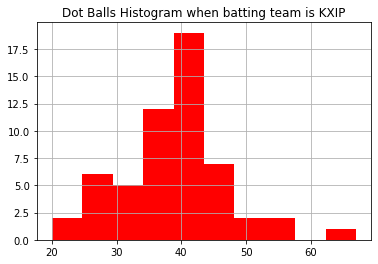

In [175]:
kxip_dot = delivery[(delivery['batting_team']==team_1)& (delivery['total_runs']==0)].groupby('match_id').count()['total_runs']
kxip_dot.hist(color='red')
print(kxip_dot.describe())
plt.title("Dot Balls Histogram when batting team is KXIP")

count    29.000000
mean     37.241379
std       8.898857
min       8.000000
25%      33.000000
50%      38.000000
75%      43.000000
max      56.000000
Name: total_runs, dtype: float64


Text(0.5, 1.0, 'Dot Balls Histogram when batting team is RR')

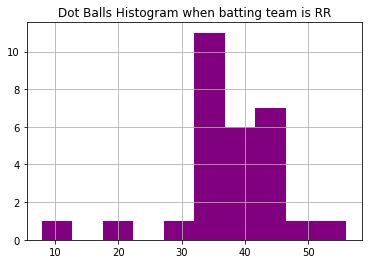

In [174]:
rr_dot = delivery[(delivery['batting_team']==team_2)& (delivery['total_runs']==0)].groupby('match_id').count()['total_runs']
rr_dot.hist(color='purple')
print(rr_dot.describe())
plt.title("Dot Balls Histogram when batting team is RR")

# Shammi Number of balls to first Wicket

,Balls to first wicket
mean,14.50000
std,5.74737
min,2.00000
25%,11.50000
50%,14.00000
75%,19.25000
max,23.00000


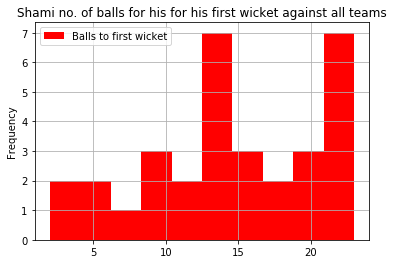

In [171]:
shami = delivery[(delivery['bowler']=='Mohammed Shami')]
balls = list()
mat_id = list()
for match_id in shami.match_id.unique():
    ball = 0
    for dismiss in shami[shami['match_id']==match_id]['player_dismissed']:
        ball += 1
        if dismiss == 1:
            break
    if (ball <= 24):
        balls.append(ball)
        mat_id.append(match_id)
    
shami_wk = pd.DataFrame(index=mat_id, data=balls, columns=['Balls to first wicket'])
shami_wk.plot(kind='hist', grid=True, color='red')
plt.title("Shami no. of balls for his for his first wicket against all teams")
shami_wk.describe()[1:]

In [172]:
shami_matches = len(shami['match_id'].unique())
shami_wickets = len(shami[(shami['player_dismissed']==1)]['match_id'].unique())
print("Percentage Chances of taking atleast one wicket in this match is:", shami_wickets*100/shami_matches, '%')

Percentage Chances of taking atleast one wicket in this match is: 76.47058823529412 %


Text(0.5, 1.0, 'Shami Wickets Histogram vs Overs')

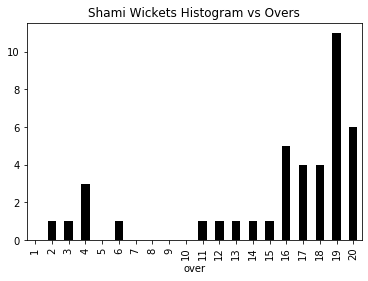

In [173]:
delivery[(delivery['bowler']=='Mohammed Shami')].groupby('over').sum()['player_dismissed'].plot( kind='bar', color='black')
plt.title("Shami Wickets Histogram vs Overs")

# Summary

1. Different central tendency measures were plotted and compared for both the teams total match score. The winning chances of both the team were calculated using the winner column when played against each other. 
2. The data was filtered wrt predicted players today, and boundaries and total runs by each player per match played were calculated using batsman_runs column and constraining it for boundaries. And ratios were calculated using the formula and graphed.
3. All the parameters required for OPP calculation was calculated using batsman_runs column and constraining for boundaries. Normalize function was created using the formula given and applied to data and the results of opp were summed and graphed. 
4. Individual team dot balls per match was calculated using total_runs column by filtering when the value is 0 and histogram plotted. 
5. Chances of taking wicket was calculated and wickets vs overs and histogram of balls to the first wicket were graphed for Shammi. 